In [ ]:
from google.colab import drive
drive.mount('content/')

In [ ]:
# %cd /content/content/MyDrive/mini_project
# !unzip -qq "/content/content/MyDrive/archive.zip"


In [ ]:
# 먼저 실행해주세요!

import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
from PIL import Image
plt.style.use(['seaborn-v0_8-whitegrid'])

### Image segmentation
``` python
Image segmentation은 이미지를 여러 개의 픽셀 집합으로 나누는 Task입니다.
단순하게 말하면, 이미지의 각 픽셀을 임의의 Class로 분류해주는 Task이기도 합니다.

아래의 그림처럼 RGB 이미지를 넣으면, 각 클래스로 분할된 마스크가 결과가 나오도록 모델을 설계하면 됩니다.
```
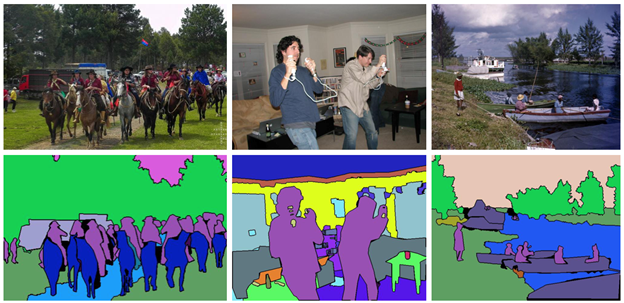

### Forest Aerial Images for Segmentation
``` python
Kaggle에서 제공하는 데이터로 데이터 구조는 아래와 같습니다.

Forest Segmented/
│
├── images
│     ├── 855_sat_01.jpg
│     ├── 855_sat_02.jpg
│     ├── ...
│
├── masks
│     ├── 855_mask_01.jpg
│     ├── 855_mask_02.jpg
│     ├── ...
│
├──  meta_data.csv

```
데이터 출처 :
https://www.kaggle.com/datasets/quadeer15sh/augmented-forest-segmentation?resource=download

### 데이터 확인 및 준비
``` python
프로젝트 주제와 데이터를 선정했다면, 데이터를 찾고 살펴보는 일이 가장 먼저 진행되어야 합니다.

이 단계에서는 데이터가 저장된 형식, 그리고 데이터의 특징을 살핍니다.
이후, 이를 바탕으로 Custom dataset, dataloader를 만들어주면 됩니다.

본 프로젝트에서는 메타 데이터(csv)를 활용하여 데이터를 다뤄보겠습니다.
```

In [ ]:
%cd /content/content/MyDrive/mini_project

In [ ]:
!ls

In [ ]:
df_path = '/content/content/MyDrive/mini_project/data/meta_data.csv'
df = pd.read_csv(df_path)

print(len(df))
df.head()

In [ ]:
base_dir = 'data'
img_dir = os.path.join(base_dir, 'images')
mask_dir = os.path.join(base_dir, 'masks')

print(img_dir)
print(mask_dir)

In [ ]:
# 데이터 시각화

for i in range(1,6):
    plt.subplot(2,5,i)
    img_path = os.path.join(img_dir, df['image'][i])
    img = plt.imread(img_path)
    plt.axis('off')
    plt.title('img_{}'.format(i))
    plt.imshow(img)

    plt.subplot(2,5,5+i)
    mask_path = os.path.join(mask_dir, df['mask'][i])
    mask = plt.imread(mask_path)
    plt.axis('off')
    plt.title('mask_{}'.format(i))
    plt.imshow(mask)

plt.show()

#### Custom Dataset

In [ ]:
# 모든 데이터 셋의 기초가 되는 클래스

from torch.utils.data import Dataset

class BaseDataset(Dataset):

    def __init__(self, data, transform=None, val=False, test=False):
        """
        필요한 변수들을 선언하거나, 메타 데이터 혹은 데이터 전체를 로드해준다.

        """
        self.data = None

        super().__init__()

    def __len__(self):
        """
        데이터의 총 크기를 반환하는 함수

        """
        return(len(self.data))

    def __getitem__(self, index):
        """
        index를 활용해 데이터의 일부를 반환해주는 함수

        :return: data[index] -> 텐서로 반환해야 한다.
        """

        raise NotImplementedError

In [ ]:
class ForestDataset(Dataset):

    def __init__(self, base_dir, data, transform=None, test=False):
        self.data = pd.read_csv(data)  # data : meta data가 저장된 경로
        if test:
            self.data = self.data[int(len(self.data)*0.9):]
        else:
            self.data = self.data[:int(len(self.data)*0.9)]
        self.transform = transform
        self.base_dir = base_dir
        super().__init__()

    def __len__(self):
        return(len(self.data))

    def __getitem__(self, index):
        img_dir = os.path.join(self.base_dir, 'images')
        mask_dir = os.path.join(self.base_dir, 'masks')

        # image
        img_path = os.path.join(img_dir, self.data.iloc[index, 0])
        image = np.array(Image.open(img_path).convert("RGB"), dtype=np.float32)  # image 경로를 활용해서 이미지를 읽어온다. Red, Green, Blue
        image = image / 255.0  # 정규화  -> 0~1

        # mask
        mask_path = os.path.join(mask_dir, self.data.iloc[index, 1])
        mask = np.array(Image.open(mask_path).convert("L"), dtype=np.float32)  # mask -> channel이 한 개인 이미지(흑백)
        mask = mask / 255.0  # 검정색 : 0, 흰색 : 1, 255


        # transform(=augmentation)
        if self.transform is not None:
            augmentations = self.transform(image=image, mask=mask)  # Albumentation 라이브러리를 사용하는 방법(이미지 증강용 라이브러리)
            image = augmentations["image"]
            mask = augmentations["mask"]

        return image, mask

In [ ]:
# Data Augmentation

import albumentations as A
from albumentations.pytorch import ToTensorV2

'''
데이터에 여러가지 변형을 넣어줍니다.

일반화 성능을 높이거나, 데이터 양이 부족할 때 주로 사용합니다.
'''

train_transform_list = [
    ToTensorV2()
]

test_transform_list = [
    ToTensorV2()
]

train_transform = A.Compose(transforms=train_transform_list, is_check_shapes=False)

test_transform = A.Compose(transforms=test_transform_list, is_check_shapes=False)

In [ ]:
train_dataset = ForestDataset(base_dir, df_path, train_transform, False)
test_dataset = ForestDataset(base_dir, df_path, test_transform, True)

# -> train(train_loader, valid_loader), test_loader

In [ ]:
image, mask = train_dataset[0]

print(image.shape)
print(mask.shape)

In [ ]:
plt.subplot(1,2,1)
plt.axis('off')
plt.title('img')
plt.imshow(image.permute(1,2,0))

plt.subplot(1,2,2)
plt.axis('off')
plt.title('mask')
plt.imshow(mask)

plt.show()

#### Custom DataLoader

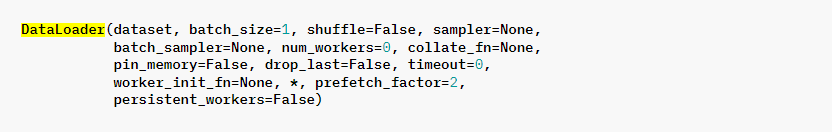

In [ ]:
# 모든 데이터 로더의 기초가 되는 클래스

import numpy as np
from torch.utils.data import DataLoader

class BaseDataLoader(DataLoader):

    def __init__(self, dataset_root: str, batch_size, shuffle, num_workers, validation_split):

        self.dataset_root = dataset_root
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.num_workers = num_workers
        self.validation_split = validation_split

        super().__init__()


    def split_validation(self):
        """
        위에서 정의한 _split_sampler를 활용하여 샘플링해주는 함수

        :return: DataLoader(sampler, **self.init_kwargs)
        """
        #return DataLoader(sampler=self.sampler, **self.init_kwargs)


    def _get_dataset(self, dataset_class, dataset_name, transform=None):
        """
        미리 만들어둔 데이터 셋 클래스를 활용하여 데이터 셋을 정의하는 함수

        - dataset_class : 미리 정의해둔 데이터 셋 클래스
        - dataset_name : 데이터 셋 이름(데이터 위치 찾을 때 활용)
        - transform : 데이터에 적용할 transform 종류

        :return: train_dataset, test_dataset
        """

        #return train_dataset, test_dataset


    def get_dataloader(self, batch_size):
        """
        데이터 로더를 정의하는 함수

        :return: trainloader, validationloader, testloader
        """

In [ ]:
class ForestDataLoader(DataLoader):

    def __init__(self, batch_size, train_transform, test_transform, dataset_class, dataset_name = 'cifar'):

        self.batch_size = batch_size
        self.train_transform = train_transform
        self.test_transform = test_transform

        # 다양한 데이터 셋 활용할 때 사용하면 좋은 방법
        self.dataset_class = dataset_class
        self.dataset_name = dataset_name

        self.train_valid_split = 0.1  # train data의 10%를 validation data로 활용하겠다

        if dataset_name == 'forest':  # train, test dataset 만든다
            self.train_dataset = dataset_class('data', 'data/meta_data.csv', transform=self.train_transform, test=False)
            self.test_dataset = dataset_class('data', 'data/meta_data.csv', transform=self.test_transform, test=True)


    def get_loader_with_valid(self, dataset, batch_size):  # train -> train, valid + dataloader를 생성
        train_dataset, validation_dataset = torch.utils.data.random_split(
            self.train_dataset, [1-self.train_valid_split, self.train_valid_split],
            generator=torch.Generator().manual_seed(1)  # randomness 제어
        )
        train_loader = DataLoader(train_dataset, batch_size, shuffle=True, drop_last=True)
        validation_loader = DataLoader(validation_dataset, batch_size, shuffle=True, drop_last=True)
        test_loader = DataLoader(self.test_dataset, batch_size, shuffle=False, drop_last=True)

        return train_loader, validation_loader, test_loader

In [ ]:
forestloader = ForestDataLoader(32, train_transform, test_transform, ForestDataset, 'forest')
train_loader, validation_loader, test_loader = forestloader.get_loader_with_valid(ForestDataset, 32)

In [ ]:
train_img, train_mask = next(iter(train_loader))
print(f"train img batch shape: {train_img.size()}")
print(f"train mask batch shape: {train_mask.size()}")

In [ ]:
img = train_img[3]
mask = train_mask[3]
print(img.shape)
print(mask.shape)

In [ ]:
plt.subplot(1,2,1)
plt.axis('off')
plt.title('img')
plt.imshow(img.permute(1,2,0))

plt.subplot(1,2,2)
plt.axis('off')
plt.title('mask')
plt.imshow(mask)

plt.show()

### 모델 준비
``` python
데이터가 준비되었다면, 모델을 탐색할 차례입니다.

Image Segmentation 분야에서 유명한 U-Net을 직접 만들어 활용해 봅시다.
```

#### U-Net
``` python
Image Segmentation 분야의 기초 모델 중 하나입니다.

데이터를 압축하는 인코더(Encoder) 부분과
압축된 데이터를 원하는 형태로 복원하는 디코더(Decoder)로 이뤄져 있습니다.

```
https://arxiv.org/abs/1505.04597

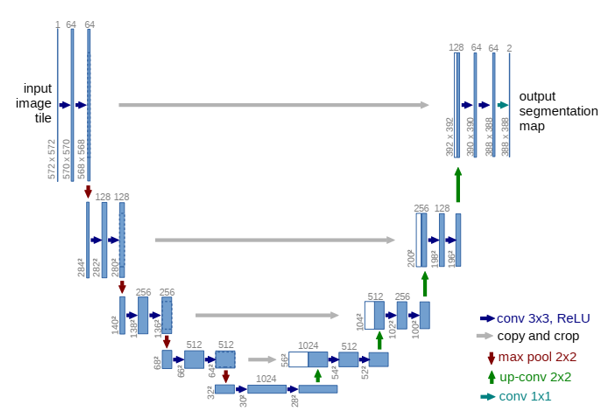

##### Convolutional Block

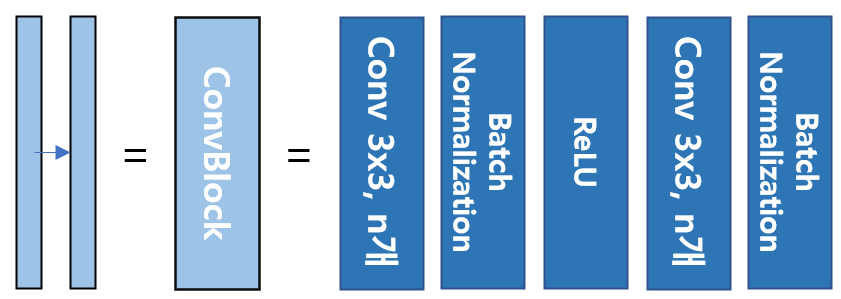

In [ ]:
# U-Net의 기본 구성 요소인 Convolution Block을 정의합니다.
def conv_block(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.BatchNorm2d(out_channels)
        )

##### Custom Model Build

In [ ]:
# 간단한 U-Net 모델 정의
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.dconv_down1 = conv_block(3, 64)
        self.dconv_down2 = conv_block(64, 128)
        self.dconv_down3 = conv_block(128, 256)
        self.dconv_down4 = conv_block(256, 512)

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.dconv_up3 = conv_block(256 + 512, 256)
        self.dconv_up2 = conv_block(128 + 256, 128)
        self.dconv_up1 = conv_block(128 + 64, 64)

        self.conv_last = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)

        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)

        x = self.dconv_down4(x)

        x = self.upsample(x)
        x = torch.cat([x, conv3], dim=1)

        x = self.dconv_up3(x)
        x = self.upsample(x)
        x = torch.cat([x, conv2], dim=1)

        x = self.dconv_up2(x)
        x = self.upsample(x)
        x = torch.cat([x, conv1], dim=1)

        x = self.dconv_up1(x)

        out = self.conv_last(x)

        return out  # 3 * 256 * 256 -> 1 * 256 * 256

#### Res U-Net
``` python
PyTorch의 torchvision 라이브러리에서는 미리 학습된 모델들이 다수 존재합니다.

미리 학습된 모델들을 불러오는 법을 알아보고, 이를 Custom 모델과 합쳐 사용해보겠습니다.
```
https://pytorch.org/vision/stable/models.html

##### Pretrained ResNet50
``` python
'ResNet'은 Residual block이라는 구조가 추가된 딥러닝 모델입니다.

기존 딥러닝 모델들이 가지고 있던 기울기가 소실되는 Gradient vaninishing 문제,
그리고 Layer를 깊게 쌓을수록 성능이 안 좋아지는 Degradation Problem 문제를 완화하며 좋은 성능을 보였는데요.

ResNet은 주로 이미지에서 특징을 뽑아내는 단계에 활용됩니다.
컴퓨터 비전 분야에서는 위와 같은 역할을 하는 모델 구조를 '백본(Backbone) 모델'이라고 부릅니다.
Objection Detection, Image Segmentation 등과 같은 보다 복잡한 Task에도 백본 모델로 ResNet이 여전히 활발히 사용되고 있는 추세입니다.

이번 실습에서는 앞서 구현한 U-Net에 미리 학습된 ResNet50 모델을 백본으로 붙여 Custom U-Net을 만들어 보겠습니다.
```

In [ ]:
from torchvision.models import resnet50, ResNet50_Weights

# Old weights with accuracy 76.130%
#resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)

# New weights with accuracy 80.858%
#resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)

# Best available weights (currently alias for IMAGENET1K_V2)
# Note that these weights may change across versions
resnet = resnet50(weights=ResNet50_Weights.DEFAULT)  # 미리 학습된 모델을 가져와서 활용하는 방식 -> fine-tuning

In [ ]:
backbone = nn.Sequential(*list(resnet.children())[:-2])  # classifier를 제외한 resnet 모델

In [ ]:
from torchsummary import summary
summary(backbone.cuda(), (3, 256, 256))

##### Custom Model build

In [ ]:
# ResNet Backbone U-Net 모델 정의 -> 만약에 pretrained 모델을 가져와서 그 layer들의 일부를 따로 떼어 활용하고 싶으면 어떻게 해야 될까?
def conv_block(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.Dropout(0.6)
        )

class ResUNet(nn.Module):
    def __init__(self):
        super(ResUNet, self).__init__()
        resnet = resnet50(weights=ResNet50_Weights.DEFAULT)  # Pretrained resnet 다운로드
        self.backbone = nn.Sequential(*list(resnet.children())[:-2])  # Classifier 부분 떼고 backbone으로 활용

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.encoder1 = self.backbone[:3]  # (3, 256, 256) -> (64, 128, 128)
        self.encoder2 = self.backbone[4]  # (64, 128, 128) -> (256, 128, 128)
        self.encoder3 = self.backbone[5] # (256, 128, 128) -> (512, 64, 64)

        self.bridge = conv_block(512, 512)

        self.decoder3 = conv_block(512 + 512, 256)
        self.decoder2 = conv_block(256 + 256, 128)
        self.decoder1 = conv_block(128 + 64, 64)

        self.conv_last = nn.Conv2d(64, 1, 1)


    def forward(self, x):
        encode_block1 = self.encoder1(x)  # (3, 256, 256) -> (64, 128, 128)
        encode_block2 = self.encoder2(encode_block1)  # (64, 128, 128) -> (256, 128, 128)
        encode_block3 = self.encoder3(encode_block2)  # (256, 128, 128) -> (512, 64, 64)

        bridge = self.bridge(encode_block3)  # (512, 64, 64) -> (512, 64, 64)
        bridge = self.maxpool(bridge)  # (512, 64, 64) -> (512, 32, 32)

        decode_block1 = self.upsample(bridge)  # (512, 32, 32)  -> (512, 64, 64)
        decode_block1 = torch.cat([decode_block1, encode_block3], dim=1)  # (512+512, 64, 64)
        decode_block1 = self.decoder3(decode_block1)  # (1024, 64, 64) -> (256, 64, 64)

        decode_block2 = self.upsample(decode_block1)  # (256, 64, 64) -> (256, 128, 128)
        decode_block2 = torch.cat([decode_block2, encode_block2], dim=1)  # (256+256, 128, 128)
        decode_block2 = self.decoder2(decode_block2)  # (512, 128, 128) -> (128, 128, 128)

        decode_block3 = torch.cat([decode_block2, encode_block1], dim=1)  # (128 + 64, 128, 128)
        decode_block3 = self.decoder1(decode_block3)  # (192, 128, 128) -> (64, 128, 128)
        decode_block3 = self.upsample(decode_block3)  # (64, 128, 128) -> (64, 256, 256)

        out = self.conv_last(decode_block3)  # (64, 256, 256) -> (1, 256, 256)

        return out

In [ ]:
resunet = ResUNet()
summary(resunet.cuda(), (3, 256, 256))

### 모델 학습 및 평가
``` python
이제 모델을 학습하고, 평가를 통해 성능을 확인해봅시다.
```

In [ ]:
model = UNet()

#### Optimizer

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))

#### Custom Criterion
``` python
복잡한 Task를 진행하다 보면, 학습에 필요한 Loss 함수를 직접 만들어야 되는 경우가 있습니다.

Image Segmentation 분야에서 자주 사용되는 DiceLoss에 대해 알아보고, 직접 구현해봅시다.
```

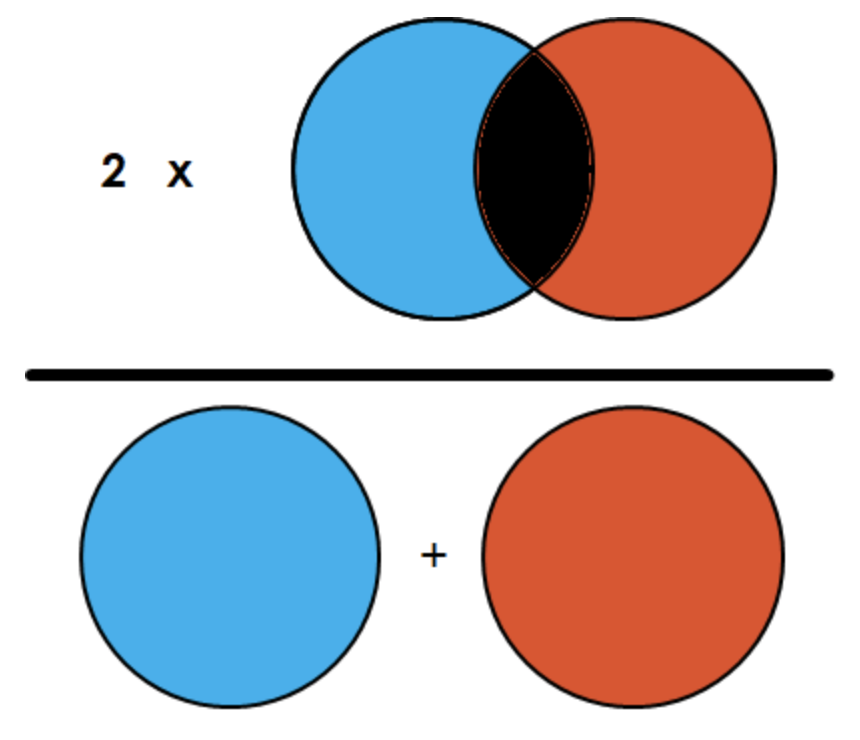

In [ ]:
import torch.nn.functional as F

class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        inputs = F.sigmoid(inputs)

        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2.*intersection + smooth) / (inputs.sum() + targets.sum() + smooth)

        return 1 - dice

In [ ]:
criterion = DiceLoss()

In [ ]:
# Loss 이외에 학습이 잘 되고 있는지 확인하기 위한 Metric을 정의하는 코드입니다.

def calculate_metrics(pred_mask, true_mask):
    pred_mask = pred_mask.float()
    true_mask = true_mask.float()

    smooth = 1
    intersection = torch.sum(pred_mask * true_mask)
    union = torch.sum((pred_mask + true_mask) > 0.5)

    # Add a small epsilon to the denominator to avoid division by zero
    iou = (intersection + smooth) / (union + smooth)
    dice_coefficient = (2 * intersection + smooth) / (
        torch.sum(pred_mask) + torch.sum(true_mask) + smooth
    )
    pixel_accuracy = torch.sum(pred_mask == true_mask) / true_mask.numel()

    return iou.item(), dice_coefficient.item(), pixel_accuracy.item()

#### Scheduler

In [ ]:
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

#### Train

In [ ]:
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
num_epochs = 10
model = UNet().to(device)

for epoch in range(num_epochs):
    # TRAINING
    model.train()
    train_loss = 0.0
    total_iou_train = 0.0
    total_pixel_accuracy_train = 0.0
    total_dice_coefficient_train = 0.0

    for images, masks in tqdm(train_loader):
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        t_loss = criterion(outputs, masks)

        t_loss.backward()
        optimizer.step()  # 모델의 가중치 업데이트

        train_loss += t_loss.item()

        # Calculating metrics for training
        with torch.no_grad():
            pred_masks = outputs > 0.5
            iou_train, dice_coefficient_train, pixel_accuracy_train = calculate_metrics(
                pred_masks, masks
            )

            total_iou_train += iou_train
            total_dice_coefficient_train += dice_coefficient_train
            total_pixel_accuracy_train += pixel_accuracy_train

    train_loss /= len(train_loader)
    avg_iou_train = total_iou_train / len(train_loader)
    avg_pixel_accuracy_train = total_pixel_accuracy_train / len(train_loader)
    avg_dice_coefficient_train = total_dice_coefficient_train / len(train_loader)

    # VALIDATION -> 가중치 업데이트 X
    model.eval()
    val_loss = 0.0
    total_iou_val = 0.0
    total_pixel_accuracy_val = 0.0
    total_dice_coefficient_val = 0.0

    with torch.no_grad():
        for images, masks in validation_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)

            v_loss = criterion(outputs, masks)
            val_loss += v_loss.item()

            # Calculating metrics for Validation
            pred_masks = outputs > 0.5
            iou_val, dice_coefficient_val, pixel_accuracy_val = calculate_metrics(
                pred_masks, masks
            )

            total_iou_val += iou_val
            total_pixel_accuracy_val += pixel_accuracy_val
            total_dice_coefficient_val += dice_coefficient_val

    val_loss /= len(validation_loader)
    avg_iou_val = total_iou_val / len(validation_loader)
    avg_pixel_accuracy_val = total_pixel_accuracy_val / len(validation_loader)
    avg_dice_coefficient_val = total_dice_coefficient_val / len(validation_loader)

    scheduler.step(val_loss)

    print(
        f"\nEpoch {epoch + 1}/{num_epochs}\n"
        f"Avg Train Loss: {train_loss:.4f}\n"
        f"Avg Validation Loss: {val_loss:.4f}\n"
        f"Avg IoU Train: {avg_iou_train:.4f}\n"
        f"Avg IoU Val: {avg_iou_val:.4f}\n"
        f"Avg Pix Acc Train: {avg_dice_coefficient_train:.4f}\n"
        f"Avg Pix Acc Val: {avg_pixel_accuracy_val:.4f}\n"
        f"Avg Dice Coeff Train: {avg_dice_coefficient_train:.4f}\n"
        f"Avg Dice Coeff Val: {avg_dice_coefficient_val:.4f}\n"
        f"{'-'*50}"
    )

    if epoch%5 == 0:
      print('-'*50)
      print('모델의 가중치를 저장합니다.')
      torch.save(model.state_dict(), 'saved/model_path_epoch{}.pth'.format(epoch))
      print('저장 완료')

##### 학습 결과

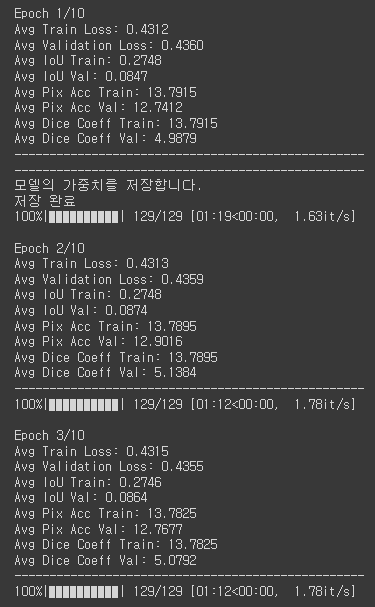

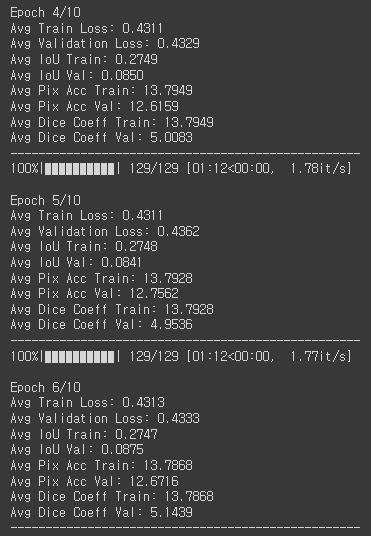

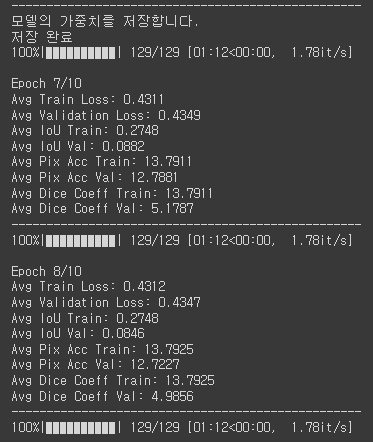

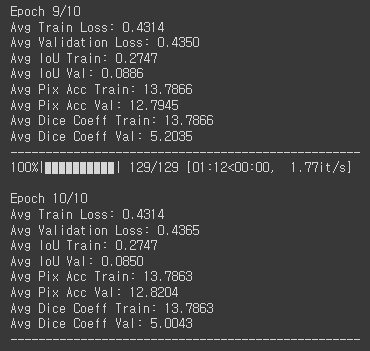

#### Test

In [ ]:
# Test 결과 시각화용 함수

def save_overlay_image(image, mask, prediction, output_img_dir: str):
    image = image.swapaxes(1,3)

    mask = np.expand_dims(mask, axis=-1)
    mask = np.concatenate([mask, mask, mask], axis=-1)

    prediction = np.expand_dims(prediction, axis=-1)
    prediction = np.concatenate([prediction, prediction, prediction], axis=-1)

    overlay = np.multiply(image, prediction)
    prediction = prediction * 255

    img_path = os.path.join(output_img_dir, 'image.png')
    mask_path = os.path.join(output_img_dir, 'mask.png')
    pred_path = os.path.join(output_img_dir, 'pred.png')
    overlay_path = os.path.join(output_img_dir, 'overlay.png')

    cv2.imwrite(img_path, image)
    cv2.imwrite(mask_path, mask)
    cv2.imwrite(pred_path, prediction)
    cv2.imwrite(overlay_path, overlay)

    print('결과가 저장되었습니다')
    return

In [ ]:
# 원하는 가중치 하나를 골라서 Test에 활용할 수 있습니다.

device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
model = UNet()
model.load_state_dict(torch.load("./saved/model_path_epoch5.pth"))  # 모델 가중치 불러오기
model.to(device)
model.eval()

In [ ]:
# test
from tqdm import tqdm

with torch.no_grad():
        for i, (image, mask) in tqdm(enumerate(test_loader)):
            image = image.to(device)

            output = model(image)
            prediction = output.cpu().numpy()[0, 0]

            image = image.cpu()[0,:,:,:].swapaxes(0,2)
            mask = mask.cpu()[0,:,:]

            if i % 3 == 0:
              plt.subplot(1,3,1)
              plt.axis('off')
              plt.title('img')
              plt.imshow(image)

              plt.subplot(1,3,2)
              plt.axis('off')
              plt.title('mask')
              plt.imshow(mask)

              plt.subplot(1,3,3)
              plt.axis('off')
              plt.title('pred')
              plt.imshow(prediction)

              plt.show()